In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from sdebridge.setup import *
from sdebridge.sde import FourierGaussianKernelSDE
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.data_processing import butterfly_amasina_pts, butterfly_honrathi_pts
from sdebridge.utils import eval_score

from matplotlib import colormaps

2024-01-26 14:38:55.530130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 14:38:55.530166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 14:38:55.531325: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 14:38:57.069124: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gefan/miniconda3/envs/sdebridge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteboo

S0 shape:  (130, 2)
ST shape:  (120, 2)


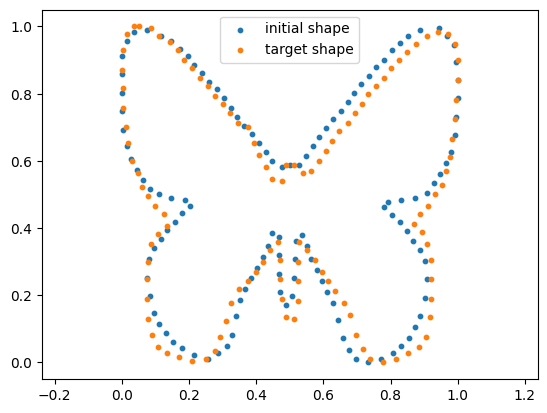

In [3]:
S0 = jnp.array(butterfly_honrathi_pts())[:, ::200][:, 1:].transpose()
ST = jnp.array(butterfly_amasina_pts())[:, ::200].transpose()

print("S0 shape: ", S0.shape)
print("ST shape: ", ST.shape)
plt.scatter(S0[:, 0], S0[:, 1], s=10, label='initial shape')
plt.scatter(ST[:, 0], ST[:, 1], s=10, label='target shape')
plt.legend()
plt.axis('equal')
plt.show()

In [6]:
n_bases = 16

sde_config = ConfigDict(
    {
        'init_S': S0,
        'T': 1.0,
        'N': 100,
        'dim': 2*n_bases,
        'sigma': 0.3,
        'alpha': 0.7,
    }
)
sde = FourierGaussianKernelSDE(sde_config)
bridge = DiffusionBridge(sde)

XT shape: 
 (16, 2)
XT (reconstructed) shape: 
 (130, 2)


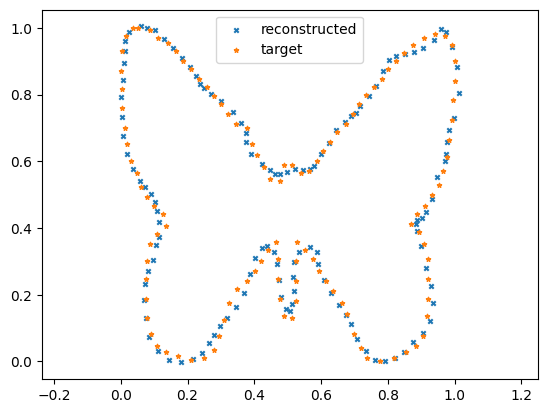

In [7]:
X0 = jnp.zeros((n_bases, 2), dtype=jnp.complex64)

S0_coeffs = jnp.fft.rfft(S0, norm="forward", n=S0.shape[0], axis=0)
ST_coeffs = jnp.fft.rfft(ST, norm="forward", n=ST.shape[0], axis=0)
XT_coeffs = ST_coeffs[:n_bases, :] - S0_coeffs[:n_bases, :]
print("XT shape: \n", XT_coeffs.shape)
XT_recon = jnp.fft.irfft(XT_coeffs, n=S0.shape[0], axis=0, norm="forward")
print("XT (reconstructed) shape: \n", XT_recon.shape)

ST_recon = S0 + XT_recon.real
plt.scatter(ST_recon[:, 0], ST_recon[:, 1], s=10, marker='x', label='reconstructed')
plt.scatter(ST[:, 0], ST[:, 1], s=10, marker='*', label='target')
plt.axis('equal')
plt.legend()

In [22]:
sde.diffusion(X0, 0.0).shape

(16, 256)

In [24]:
forward_uncond = bridge.simulate_forward_process(
    initial_val = X0,
    num_batches = 4
)

Xs_coeffs = forward_uncond["trajectories"]
Xs_recon = jnp.fft.irfft(Xs_coeffs, n=S0.shape[0], axis=2, norm="forward")
Ss = S0[None, None, :, :] + Xs_recon

(-0.10516357719898224,
 1.1452772051095963,
 -0.19662943333387375,
 1.1451775416731835)

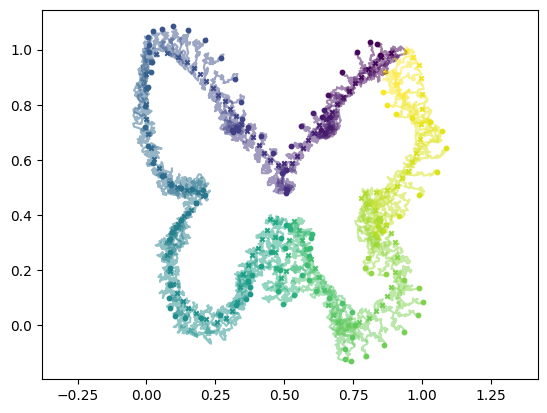

In [26]:
n = 2
cmap = colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, S0.shape[0]))
for i in range(S0.shape[0]):
    plt.scatter(Ss[n, 0, i, 0], Ss[n, 0, i, 1], s=10, marker='x', color=colors[i])
    plt.scatter(Ss[n, -1, i, 0], Ss[n, -1, i, 1], s=10, marker='o', color=colors[i])
    plt.plot(Ss[n, :, i, 0], Ss[n, :, i, 1], color=colors[i], alpha=0.5)
plt.axis('equal')